In [432]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

## Preparing Data

In [433]:
transform=transforms.Compose([transforms.ToTensor()])

In [434]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [435]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [436]:
data=data.reshape(data.shape[0],-1) 

In [437]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [438]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [439]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [440]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)

In [441]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# A2 . Logistic Regression 

###  Binary Classification Task


In [442]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [443]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [444]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [445]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [446]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [447]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [448]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [449]:
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220


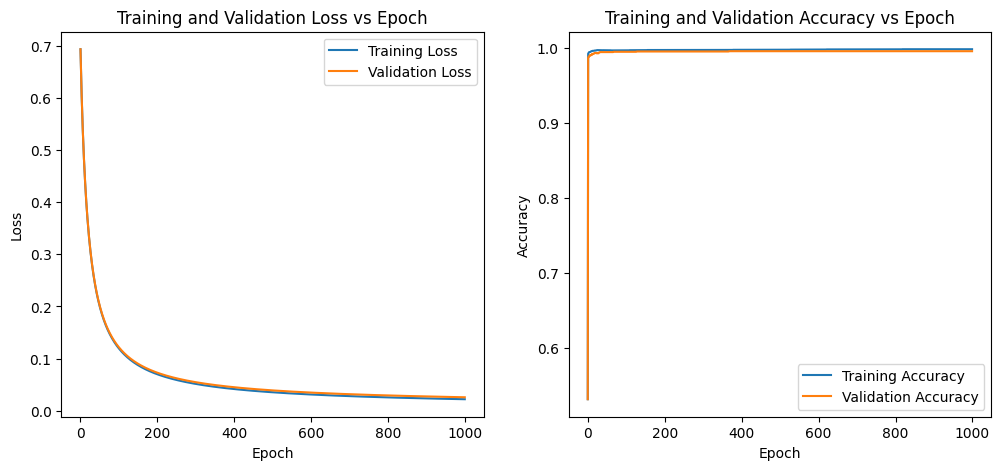

In [450]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [451]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [452]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


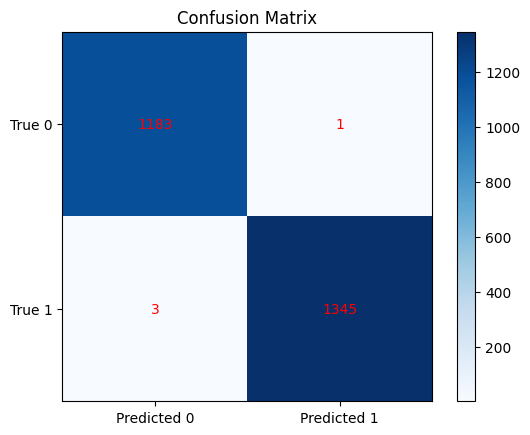

In [453]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()

# A3.Softmax Regression

### Multi-class Classification Task

In [454]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

In [455]:
def cross_entropy_loss(predictions, targets):
    num_samples = predictions.shape[0]
    log_probs = -torch.log(predictions[range(num_samples), targets])
    loss = torch.mean(log_probs)
    return loss

In [456]:
number_of_features=28*28 
number_of_classes=10

W_multi=torch.zeros((number_of_features,number_of_classes),requires_grad=True)
b_multi=torch.zeros((1,number_of_classes),requires_grad=True)

lr=0.01
num_epochs=10

In [457]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [458]:

for epoch in range(num_epochs):
    total_loss=0
    total_correct=0
    total=0
    for images,labels in training_loader:
        trained_data=images.view(-1,28*28)

        scores=linear_output(trained_data,W_multi,b_multi)
        training_predictions=softmax(scores)

        loss=cross_entropy_loss(training_predictions,labels)
        loss.backward()

        predections=torch.argmax(training_predictions,dim=1)

        total_correct+=(predections==labels).sum().item()
        total+=labels.size(0)
        total_loss+=loss.item()*labels.size(0)

        with torch.no_grad():
            W_multi-=lr*W_multi.grad
            b_multi-=lr*b_multi.grad
        W_multi.grad.zero_()
        b_multi.grad.zero_()


    training_loss=total_loss/total
    training_accuracy=total_correct/total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)


    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        total_val=0
        for val_images,val_labels in validation_loader:
            val_trained_data=val_images.view(-1,28*28)

            val_scores=linear_output(val_trained_data,W_multi,b_multi)
            val_predictions=softmax(val_scores)

            val_loss=cross_entropy_loss(val_predictions,val_labels)

            val_predections=torch.argmax(val_predictions,dim=1)

            total_val_correct+=(val_predections==val_labels).sum().item()
            total_val+=val_labels.size(0)
            total_val_loss+=val_loss.item()*val_labels.size(0)

        validation_loss=total_val_loss/total_val
        validation_accuracy=total_val_correct/total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

Epoch [1/10], Training Loss: 1.1705, Validation Loss: 0.7670
Epoch [2/10], Training Loss: 0.6549, Validation Loss: 0.5939
Epoch [3/10], Training Loss: 0.5442, Validation Loss: 0.5241
Epoch [4/10], Training Loss: 0.4908, Validation Loss: 0.4847
Epoch [5/10], Training Loss: 0.4580, Validation Loss: 0.4587
Epoch [6/10], Training Loss: 0.4353, Validation Loss: 0.4403
Epoch [7/10], Training Loss: 0.4185, Validation Loss: 0.4262
Epoch [8/10], Training Loss: 0.4052, Validation Loss: 0.4149
Epoch [9/10], Training Loss: 0.3945, Validation Loss: 0.4054
Epoch [10/10], Training Loss: 0.3856, Validation Loss: 0.3974


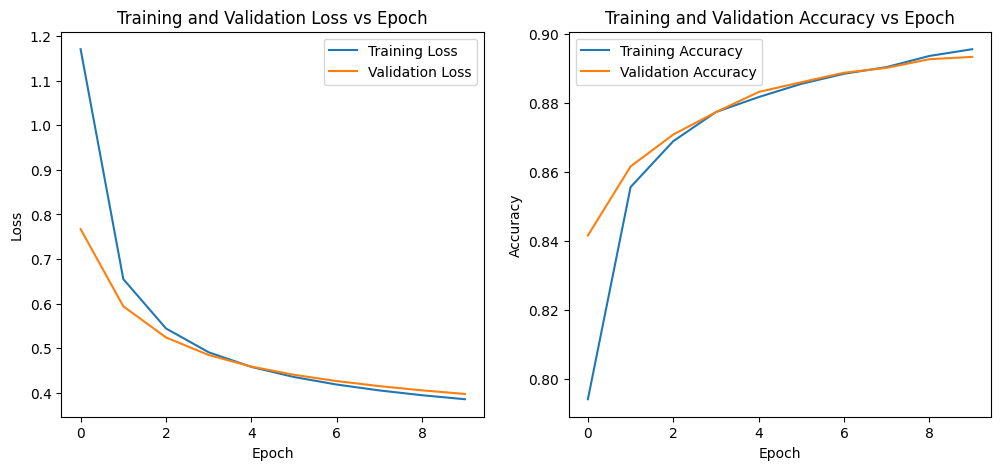

In [459]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

In [460]:
confusion_matrix_multi=torch.zeros(number_of_classes,number_of_classes,dtype=torch.int32)
total_correct=0
total=0
with torch.no_grad():
    for test_images,test_labels in testing_loader:
        test_trained_data=test_images.view(-1,28*28)

        test_scores=linear_output(test_trained_data,W_multi,b_multi)
        test_predictions=softmax(test_scores)

        test_predections=torch.argmax(test_predictions,dim=1)

        total_correct+=(test_predections==test_labels).sum().item()
        total+=test_labels.size(0)

        for true_label, pred_label in zip(test_labels, test_predections):
            confusion_matrix_multi[int(true_label.item()), int(pred_label.item())] += 1
test_accuracy=total_correct/total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 89.37%


In [462]:
print(confusion_matrix_multi)

tensor([[1135,    0,    6,    5,    4,   12,    9,    0,   13,    0],
        [   0, 1300,    5,    7,    0,    9,    3,    5,   16,    3],
        [  14,   22, 1028,   20,   21,    2,   25,   19,   33,    8],
        [  10,    6,   36, 1061,    0,   55,    6,   11,   30,   12],
        [   4,    8,   10,    2, 1054,    0,   16,    2,    8,   65],
        [  26,   17,    8,   54,   15,  875,   21,    7,   38,   23],
        [  13,    4,   18,    1,   13,   18, 1101,    0,   14,    1],
        [   7,   26,   25,    4,    8,    3,    1, 1123,    3,   53],
        [   8,   39,   15,   42,    3,   32,    7,    6,  997,   21],
        [   2,    8,    5,   15,   52,    8,    0,   35,   15, 1050]],
       dtype=torch.int32)


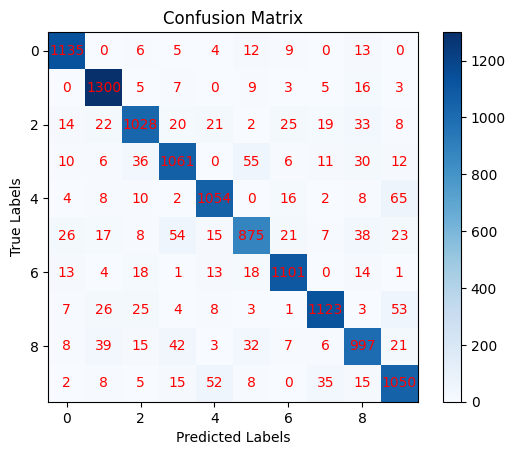

In [464]:
plt.imshow(confusion_matrix_multi, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(number_of_classes):
    for j in range(number_of_classes):
        plt.text(j, i, confusion_matrix_multi[i, j].item(), ha='center', va='center', color='red')

plt.show()

In [465]:
accuracy_per_class=confusion_matrix_multi.diagonal()/confusion_matrix_multi.sum(dim=1)
for i, accuracy in enumerate(accuracy_per_class):
    print(f'Accuracy for class {i}: {accuracy.item()*100:.2f}%')      


Accuracy for class 0: 95.86%
Accuracy for class 1: 96.44%
Accuracy for class 2: 86.24%
Accuracy for class 3: 86.47%
Accuracy for class 4: 90.16%
Accuracy for class 5: 80.72%
Accuracy for class 6: 93.07%
Accuracy for class 7: 89.62%
Accuracy for class 8: 85.21%
Accuracy for class 9: 88.24%
